In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

In [2]:
spa_adata = sc.read_h5ad("../../data/ST/intest/A1.h5ad")
sc.pp.filter_genes(spa_adata, min_cells=1)
spa_adata.obsm['spatial'] = spa_adata.obsm['spatial'][['x','y']].values
rna_adata = sc.read_csv("../../data/scRNAseq/intest/GSE125970_raw_UMIcounts.txt", '\t', first_column_names=True).T.copy()
rna_adata.obs = pd.read_csv("../../data/scRNAseq/intest/GSE125970_cell_info.txt", header=0, delimiter='\t', index_col=0).loc[rna_adata.obs_names]
classes, ct_list = leiden_cluster(rna_adata)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)

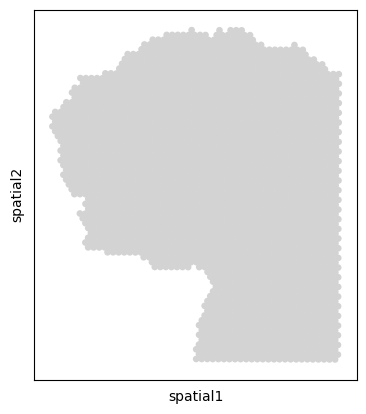

In [3]:
sc.pl.spatial(spa_adata, spot_size=100)

In [4]:
sq.gr.spatial_neighbors(spa_adata, n_neighs=6)
sq.gr.spatial_autocorr(
    spa_adata,
    # n_perms=500,
    n_jobs=50,
)
# spa_adata = spa_adata[:, ~np.isnan(spa_adata.uns['moranI'].I)].copy()
# spa_adata.uns['moranI'] = spa_adata.uns['moranI'].loc[spa_adata.var_names].copy()
spa_adata = spa_adata[:, spa_adata.uns['moranI'].I > 0].copy()
spa_adata.uns['moranI'] = spa_adata.uns['moranI'].loc[spa_adata.var_names].copy()
rna_adata, spa_adata


  0%|          | 0/500 [00:00<?, ?/s]

(AnnData object with n_obs × n_vars = 14537 × 19525
     obs: 'Sample_ID', 'CellType', 'leiden'
     uns: 'log1p',
 AnnData object with n_obs × n_vars = 2649 × 11498
     obs: 'Colonocytes', 'Crypt Top Colonocytes', 'Goblets', 'Undifferentiated', 'BEST4+/OTOP2+ Cell', 'Enteroendocrines', 'Glial', 'Stromal 2', 'Stromal 3', 'Stromal 1', 'Endothelial 1', 'Endothelial 2', 'Myofibroblasts', 'Stromal 4', 'Pericytes', 'ILCs', 'T-Cells', 'Macrophages&Monocytes', 'DC2', 'DC1', 'NK', 'Mast Cells', 'Cycling Cells', 'B-Cells', 'Plasma Cells'
     var: 'n_cells'
     uns: 'spatial_neighbors', 'moranI'
     obsm: 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [5]:
spa_adata.uns['moranI']

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
AL627309.1,-0.001563,0.457915,0.000126,0.415585,0.225549,0.000087,0.500000,0.486226,0.270920
AL669831.5,-0.009763,0.201343,0.000126,0.117556,0.001996,0.000065,0.412095,0.232382,0.004666
LINC00115,-0.004538,0.355322,0.000126,0.291308,0.341317,0.000069,0.500000,0.449180,0.375405
FAM41C,-0.003689,0.383904,0.000126,0.315230,0.001996,0.000072,0.500000,0.470679,0.004666
AL645608.1,-0.004037,0.372103,0.000126,0.342885,0.001996,0.000088,0.500000,0.486226,0.004666
...,...,...,...,...,...,...,...,...,...
AC016394.2,-0.003706,0.383331,0.000126,0.323598,0.001996,0.000073,0.500000,0.477913,0.004666
ECD,0.025557,0.010377,0.000126,0.001092,0.007984,0.000069,0.038555,0.003879,0.015791
FAM149B1,0.024320,0.013830,0.000126,0.001181,0.007984,0.000065,0.049449,0.004165,0.015791
DNAJC9,0.017361,0.056865,0.000126,0.011444,0.013972,0.000061,0.159035,0.032132,0.025858


In [6]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((2649, 11498), (14537, 19525), (8885,))

In [7]:
spa_shared = spa_adata[:, raw_shared_gene].copy()
rna_shared = rna_adata[:, raw_shared_gene].copy()
raw_spatial_df  = pd.DataFrame(spa_shared.X, columns=spa_shared.var_names)
raw_scrna_df    = pd.DataFrame(rna_shared.X, columns=rna_shared.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((2649, 8885), (14537, 8885), (8885,))

In [ ]:
spa_shared.uns['moranI'].loc[raw_shared_gene]

In [ ]:
np.random.seed(42)
neg_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values >= 0.01], 50, replace=False)
pos_genes = np.random.choice(spa_shared.var_names[spa_shared.uns['moranI'].loc[raw_shared_gene].pval_norm_fdr_bh.values < 0.01], 50, replace=False)

train_gene = np.union1d(pos_genes, neg_genes)
test_gene = np.setdiff1d(raw_shared_gene, train_gene)
len(np.unique(train_gene)), len(test_gene)

(100, 15699)

In [12]:
df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

# for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
print(f"\n==========\nNumber of train genes: {len(train_gene)}, Number of test genes: {len(test_gene)}")

test_spatial_df = raw_spatial_df[test_gene]
spatial_df = raw_spatial_df[train_gene]
scrna_df   = raw_scrna_df

df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        clip_max=2,
        mapping_lowdim=128,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

df_transImpCls[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        signature_mode='cluster',
        mapping_mode='full',
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

df_transImp[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        mapping_lowdim=128,
        mapping_mode='lowrank',
        clip_max=2,
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

df_transImpClsSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        ct_list=ct_list,
        classes=classes,
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        signature_mode='cluster',
        mapping_mode='full',
        seed=seed,
        device=device)

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "tmp_stvisp", top_k=100, verbose=False, random_seed=seed, device=device)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
np.median(corr_transImp_res), "(TransImp)", 
np.median(corr_transImpCls_res), "(TransImpCls)", 
np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
np.median(corr_res_stplus), "(stPlus)", 
np.median(corr_res_spaGE), "(spaGE)",
np.median(corr_res_tangram), "(Tangram)"
)


Number of train genes: 100, Number of test genes: 15699


[TransImp] Epoch: 1000/1000, loss: 1.035269, (IMP) 1.034559, (SPA) 1.0 x 0.000710: 100%|██████████| 1000/1000 [00:04<00:00, 217.95it/s]


In [ ]:
df_transImp.to_csv('../../output/intestext_singlecell_transImpute.csv')
df_transImpSpa.to_csv('../../output/intestext_singlecell_transImpSpa.csv')
df_transImpCls.to_csv('../../output/intestext_singlecell_transImpCls.csv')
df_transImpClsSpa.to_csv('../../output/intestext_singlecell_transImpClsSpa.csv')
df_spaGE_res.to_csv('../../output/intestext_singlecell_spaGE.csv')
df_stplus_res.to_csv('../../output/intestext_singlecell_stPlus.csv')
df_tangram_res.to_csv('../../output/intestext_singlecell_Tangram.csv')
test_spatial_df.to_csv('../../output/intestext_singlecell_truth.csv')


In [ ]:
dict_df = {
        "TransImp":df_transImp[test_gene], 
           "TransImpSpa":df_transImpSpa[test_gene], 
           "TransImpCls":df_transImpCls[test_gene],
           "TransImpClsSpa":df_transImpClsSpa[test_gene],
           "spaGE": df_spaGE_res[test_gene], 
           "stPlus": df_stplus_res[test_gene], 
           "Tangram":df_tangram_res[test_gene]
        }

dict_adata = {name: compute_autocorr(spa_shared[:, test_gene].copy(), df) for name, df in dict_df.items()}


In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings



with open("../../output/intestext_small_train_genes.pkl", 'wb') as outfile:
    pickle.dump((train_gene, test_gene), outfile)

warnings.filterwarnings('ignore')
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
eval_res_path = "../../output/intestext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01


In [ ]:
spa_shared

AnnData object with n_obs × n_vars = 293 × 7168
    obs: 'B', 'CAF', 'Endo', 'Macro', 'Melanoma or unclassified', 'NK', 'T'
    uns: 'spatial_neighbors', 'moranI'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [ ]:
if is_reeval:
    spa_adata = spa_shared[:, test_gene].copy()
    df_spa = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)

    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'is_sig':{}, 'I':{}, 'spatialDE_stats':{}, 'spatialDE_qvals':{}}
    for method  in tqdm(['stPlus', 'spaGE', 'Tangram', 'TransImp', 'TransImpSpa', 'TransImpCls', 'TransImpClsSpa']):
   
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        imp_adata = dict_adata[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue

       
        is_sig = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['is_sig'][method] = pd.Series(is_sig, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)


100%|██████████| 7/7 [00:22<00:00,  3.16s/it]


In [ ]:
np.unique(spa_adata.uns['moranI'].pval_norm_fdr_bh < .01, return_counts=True)

(array([False,  True]), array([15340,   806]))

In [ ]:

df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_issig     = pd.DataFrame(dict(sorted(eval_res['is_sig'].items())))
df_spatialDE_stats = pd.DataFrame(dict(sorted(eval_res['spatialDE_stats'].items())))
df_spatialDE_pvals = pd.DataFrame(dict(sorted(eval_res['spatialDE_qvals'].items())))

df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_issig['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_issig.index.values,:].I

imp_adatas = dict(sorted(imp_adatas.items()))
df_issig

,Tangram,TransImp,TransImpCls,TransImpClsSpa,TransImpSpa,spaGE,stPlus,truth
A1BG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e-01
A2M,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.129924e-09
AAAS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.378774e-01
AACS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e-01
AAED1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000e-01
...,...,...,...,...,...,...,...,...
ZSWIM6,0.151204,0.464002,0.294579,0.001467,0.005912,0.040694,0.081192,5.000000e-01
ZSWIM7,0.136421,0.417817,0.283685,0.001056,0.003585,0.034856,0.072739,5.000000e-01
ZW10,0.127486,0.405947,0.278916,0.000800,0.003523,0.033581,0.065217,5.000000e-01
ZYX,0.123083,0.368825,0.202252,0.000717,0.001043,0.030067,0.056994,4.891319e-01


(Tangram) Valid genes: 4669/7068
Tangram
FPR: 0.922389
(TransImp) Valid genes: 4669/7068
TransImp
FPR: 0.992988
(TransImpSpa) Valid genes: 4669/7068
TransImpSpa
FPR: 0.807060
(spaGE) Valid genes: 4669/7068
spaGE
FPR: 0.888540
(stPlus) Valid genes: 4669/7068
stPlus
FPR: 0.883704


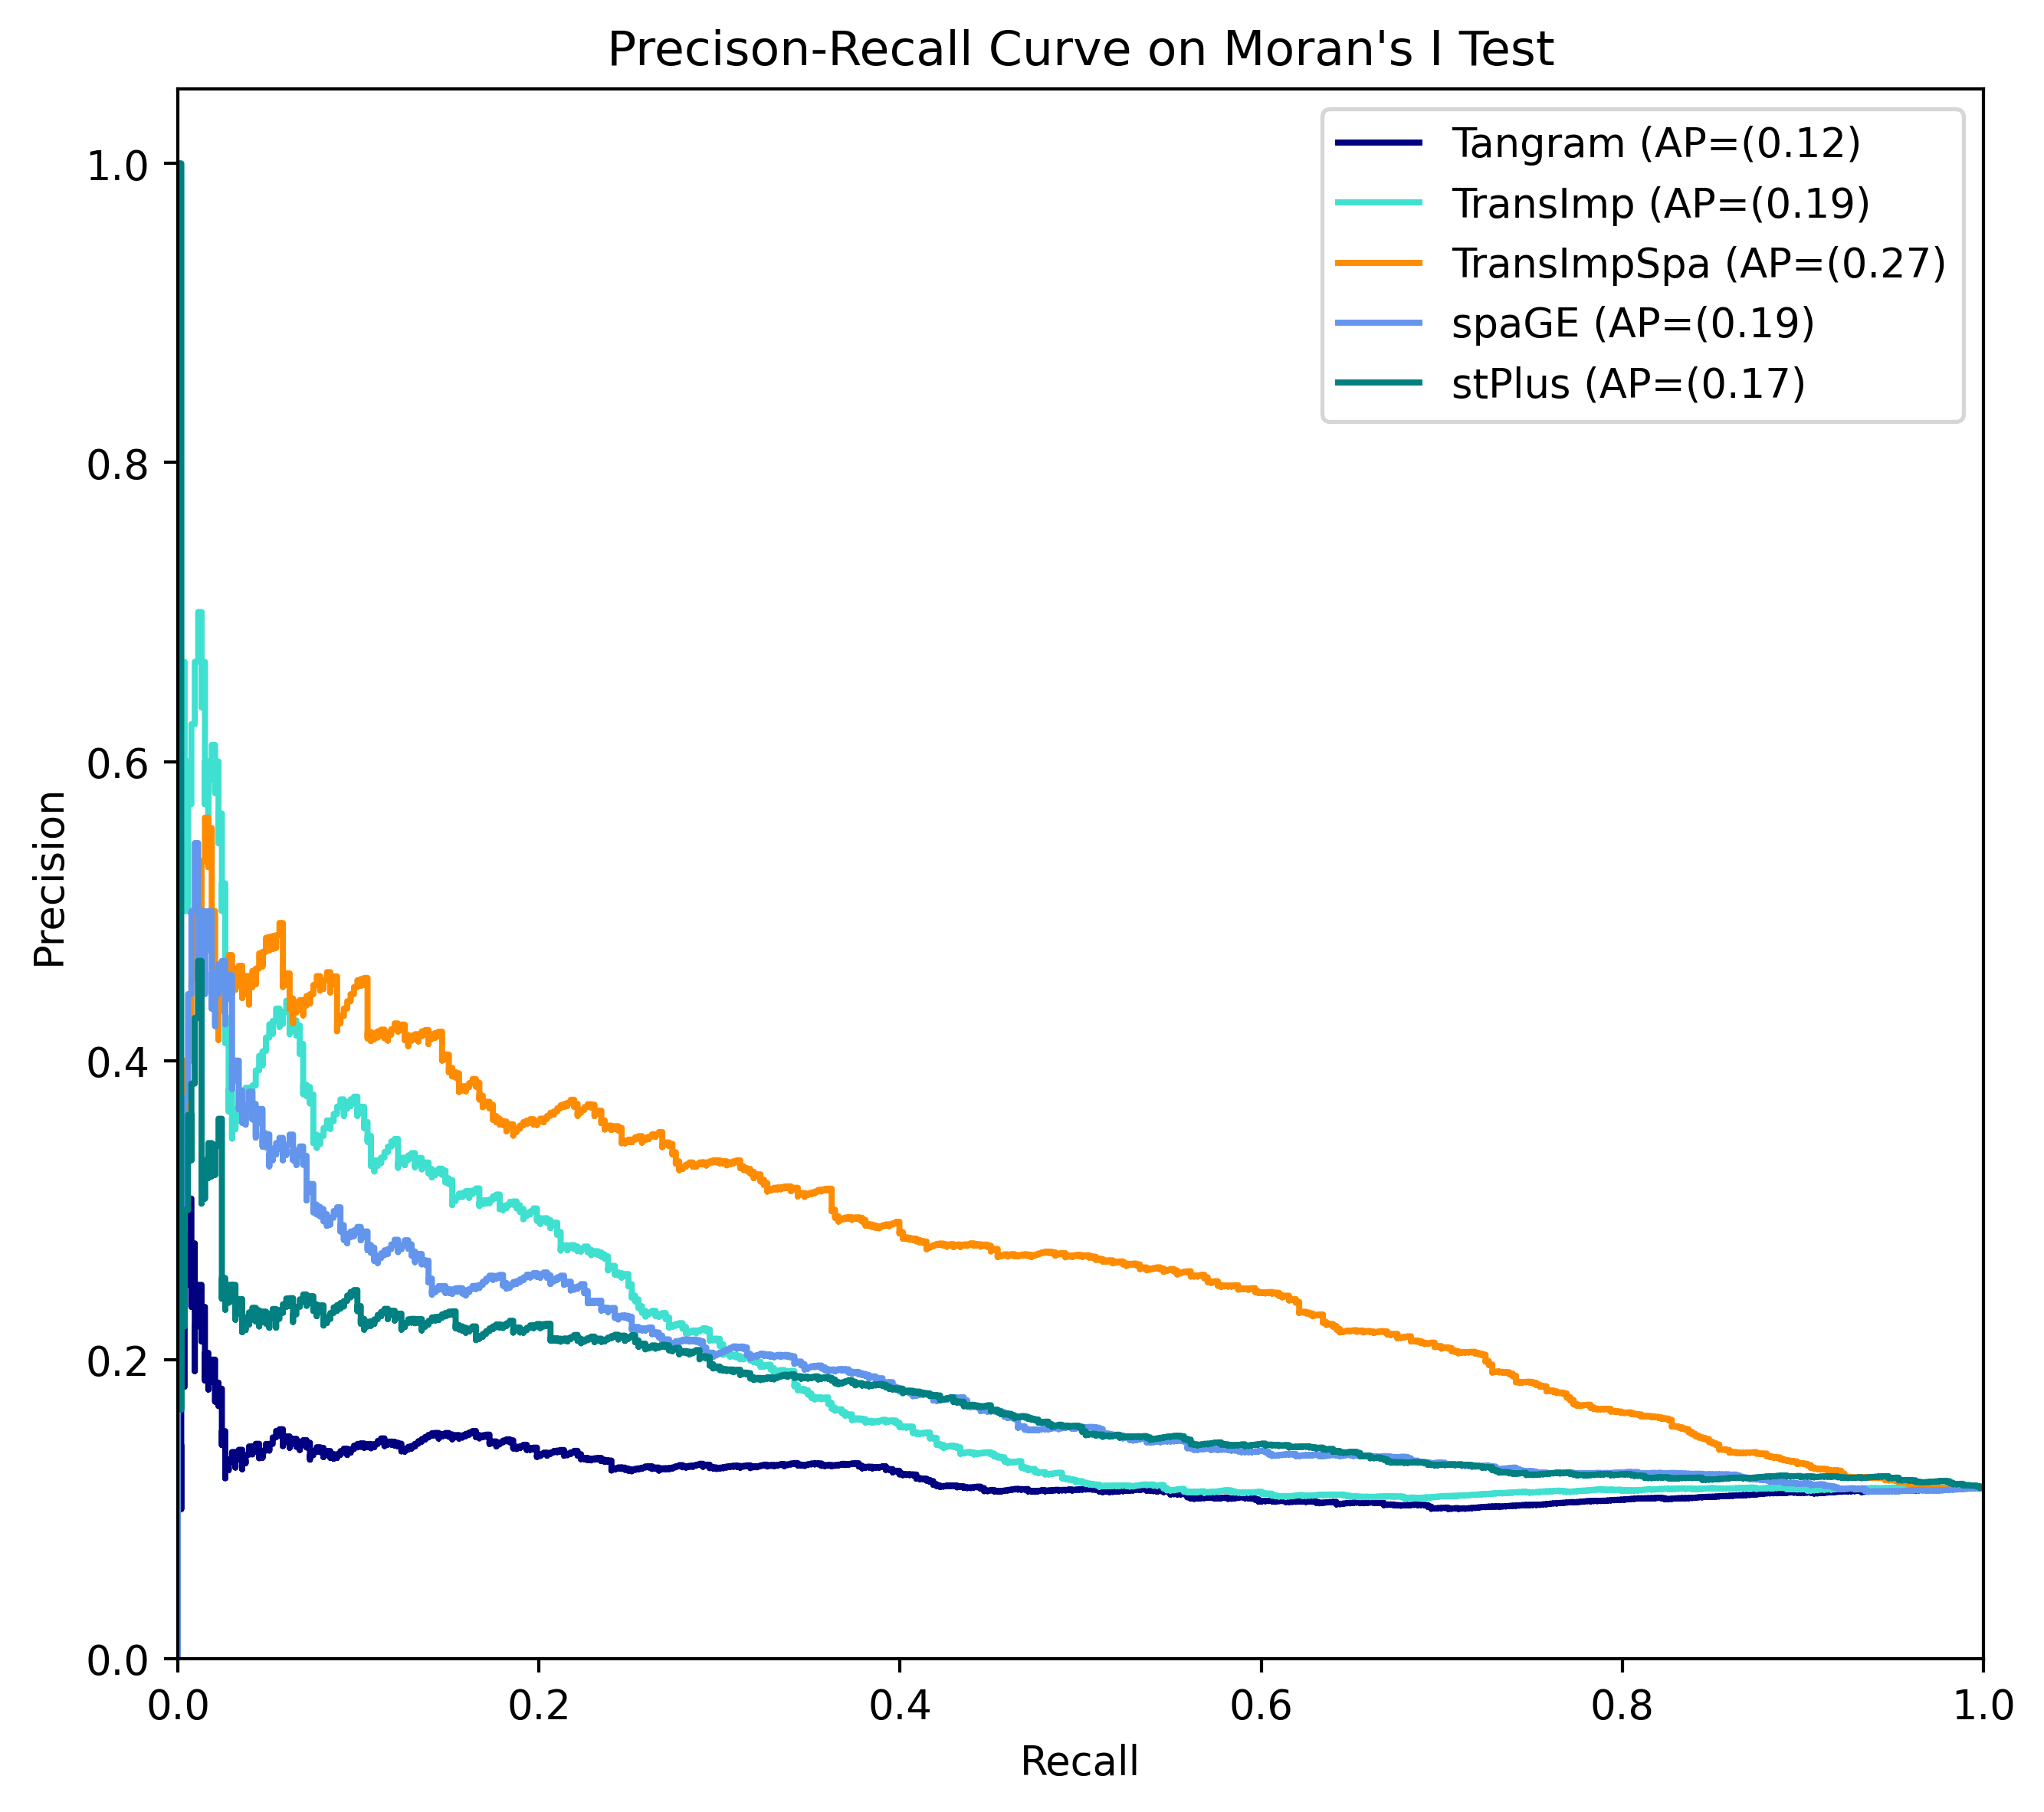

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred

    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(y < thred, I, pos_label=1)
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(y < thred, I):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 4669/7068
Tangram
FPR: 0.922389
(TransImp) Valid genes: 4669/7068
TransImp
FPR: 0.992988
(TransImpSpa) Valid genes: 4669/7068
TransImpSpa
FPR: 0.807060
(spaGE) Valid genes: 4669/7068
spaGE
FPR: 0.888540
(stPlus) Valid genes: 4669/7068
stPlus
FPR: 0.883704


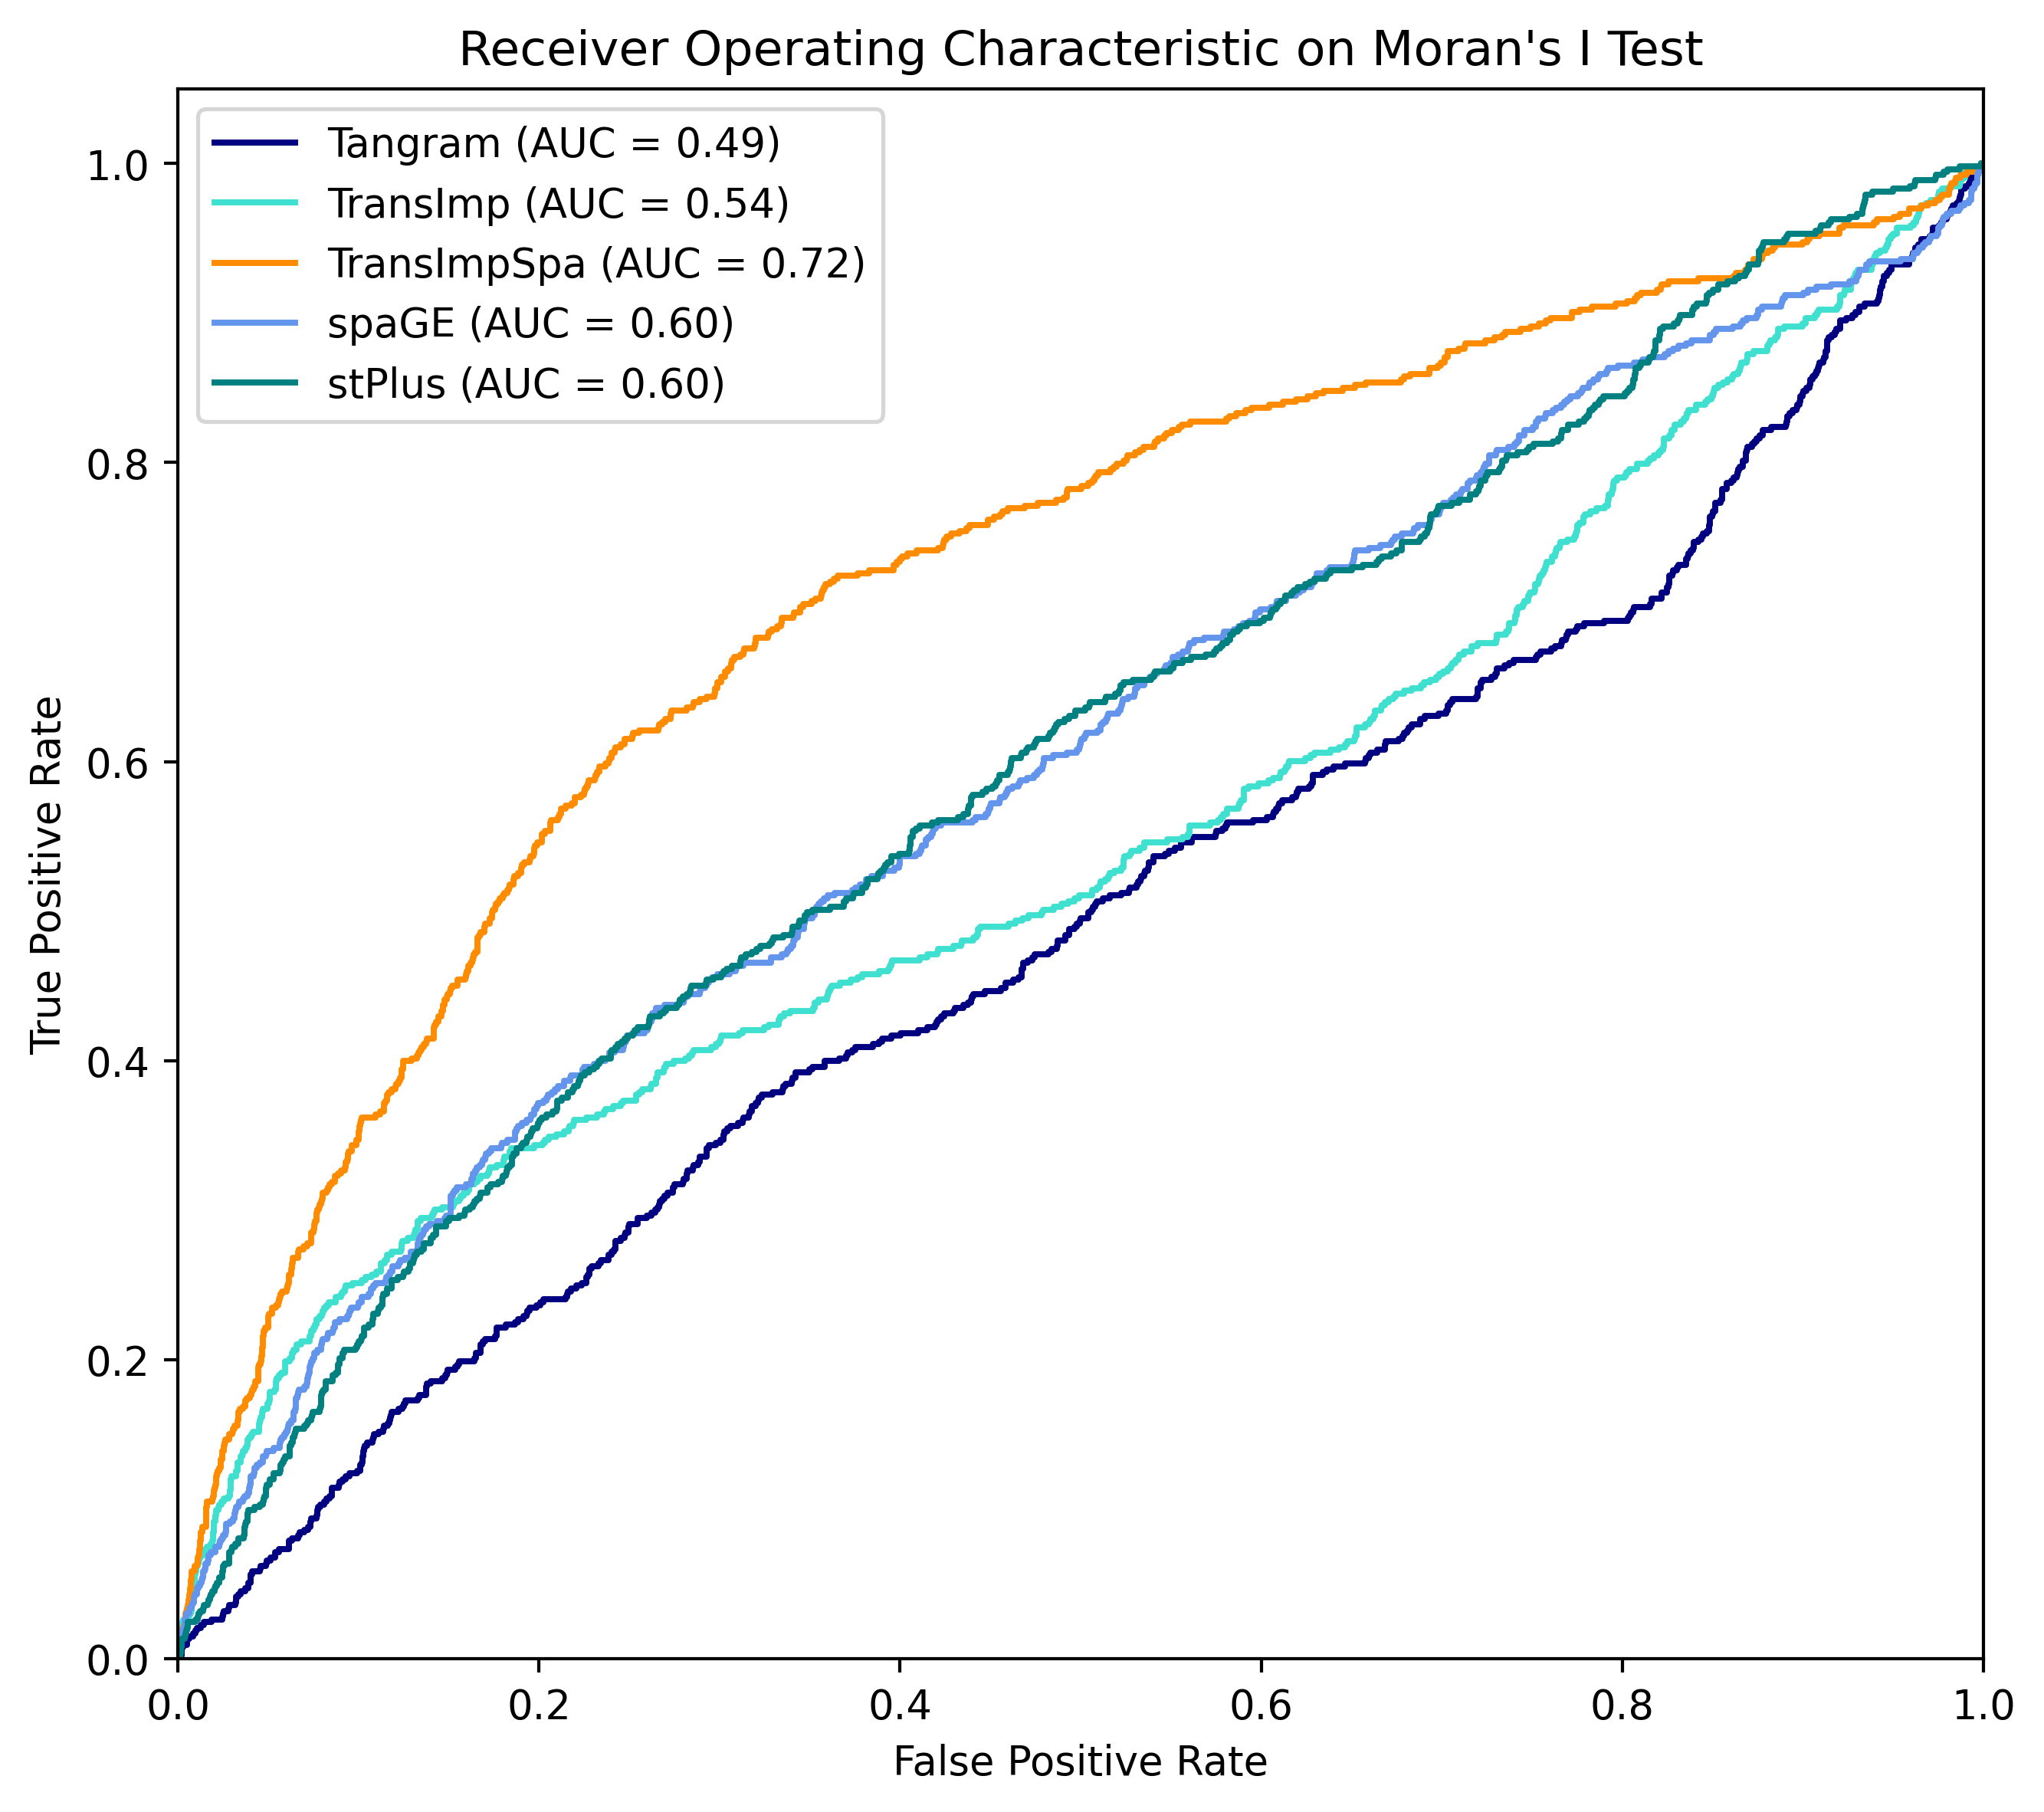

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    fpr, tpr, thresholds  = metrics.roc_curve(y < thred, I, pos_label=1)
       
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {metrics.roc_auc_score(y < thred, I):.2f})", color=color[idx])
    


ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 4669/7068
Tangram
FPR: 0.922389
prec: 0.1191410759639806, recl: 0.9681050656660413,  F1: 0.21217105263157895
(TransImp) Valid genes: 4669/7068
TransImp
FPR: 0.992988
prec: 0.11467988790687648, recl: 0.99812382739212,  F1: 0.205723124516628
(TransImpCls) Valid genes: 4669/7068
TransImpCls
FPR: 0.951402
prec: 0.11751513792330119, recl: 0.9831144465290806,  F1: 0.2099358974358974
(TransImpClsSpa) Valid genes: 4669/7068
TransImpClsSpa
FPR: 0.495890
prec: 0.12012012012012012, recl: 0.525328330206379,  F1: 0.19553072625698326
(TransImpSpa) Valid genes: 4669/7068
TransImpSpa
FPR: 0.807060
prec: 0.12181004998684557, recl: 0.8686679174484052,  F1: 0.21365943700969084
(spaGE) Valid genes: 4669/7068
spaGE
FPR: 0.888540
prec: 0.1189163270198993, recl: 0.9305816135084428,  F1: 0.21088435374149658
(stPlus) Valid genes: 4669/7068
stPlus
FPR: 0.883704
prec: 0.1190648348999759, recl: 0.926829268292683,  F1: 0.2110209312259718


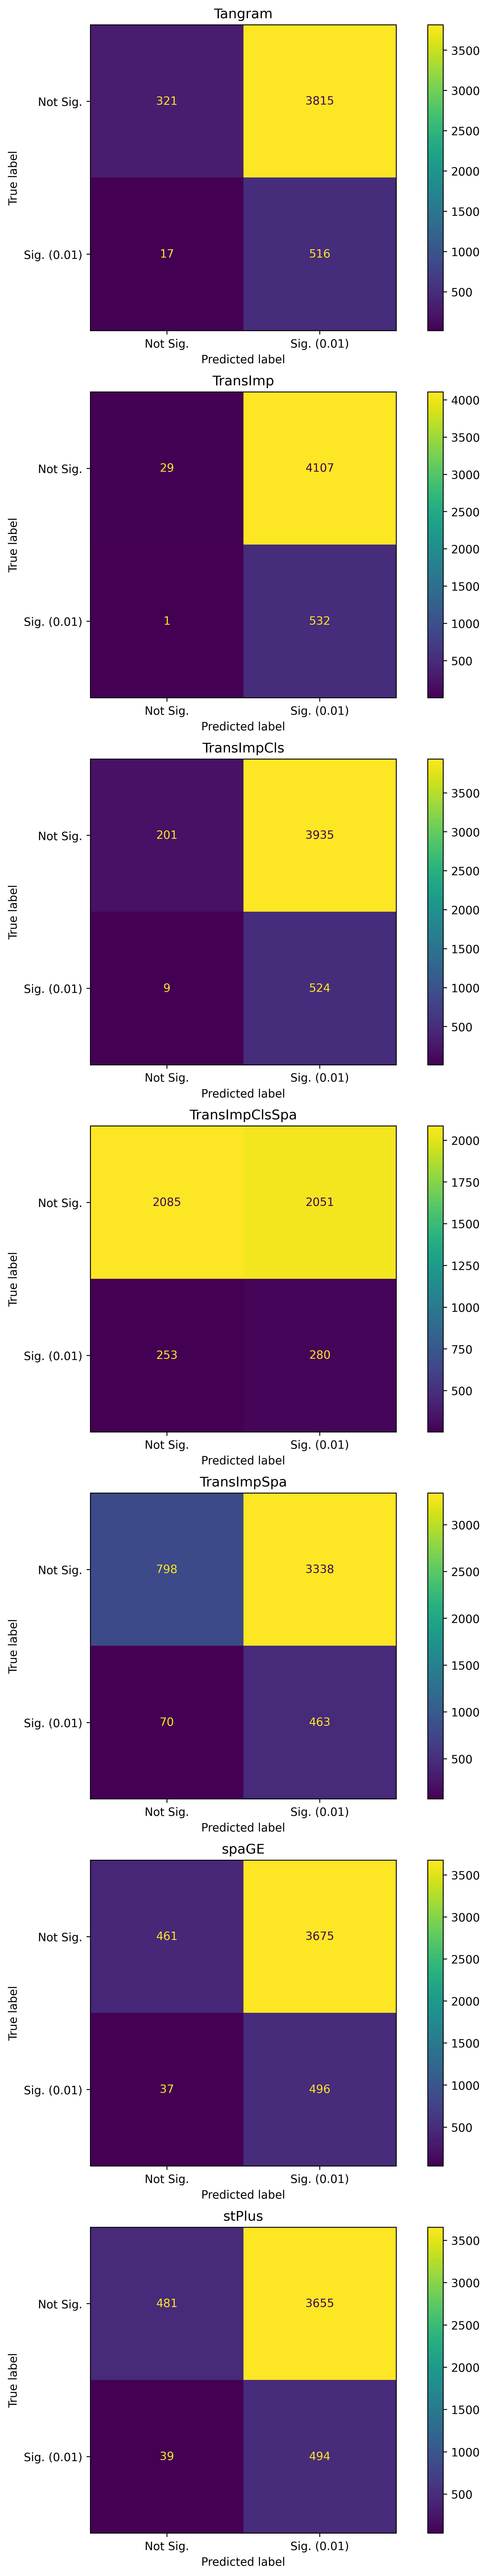

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values > 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    y, score = df_issig.truth.values[sel], df_issig[method][sel]
    I = df_I[method][sel]
    
    print(method)
    preds = score < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(y < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(y < thred, preds)}, recl: {metrics.recall_score(y < thred, preds)},  F1: {metrics.f1_score(y < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

## SparkX

In [ ]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r intest

[1] "transImpute"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 293 
## number of total genes: 7068 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "transImpSpa"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 293 
## number of total genes: 7068 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## T

In [ ]:
methods = ["transImpute", "transImpSpa", "transImpCls", "transImpClsSpa", "spaGE", "stPlus", "Tangram", "truth"]
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None
name_mapping = {"transImpute":"TransImp", "transImpSpa":"TransImpSpa", "transImpCls":"TransImpCls", "transImpClsSpa":"TransImpClsSpa"}
for md in methods:
    df = pd.read_csv(f"../../output/sparkx_intest_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    if md in name_mapping:
        md = name_mapping[md]
        
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

(            TransImp   TransImpSpa   TransImpCls  TransImpClsSpa  \
 A1BG    4.675401e-19  1.009415e-12  2.358173e-18    1.341771e-11   
 A2M     4.207073e-26  1.645768e-18  6.387445e-17    9.967519e-09   
 AAAS    3.330669e-15  1.663682e-09  3.120158e-20    1.025972e-09   
 AACS    2.313261e-12  1.285799e-07  2.553513e-15    1.569296e-05   
 AAED1   1.633888e-19  2.007283e-13  7.328064e-20    2.541011e-09   
 ...              ...           ...           ...             ...   
 ZSWIM6  2.309008e-09  2.863748e-08  1.365537e-02    5.358730e-02   
 ZSWIM7  1.719563e-03  4.355607e-03  2.598893e-02    4.094006e-01   
 ZW10    9.454437e-11  4.179928e-06  5.037415e-12    1.236648e-03   
 ZYX     6.610637e-05  4.938027e-03  2.260377e-03    4.387102e-02   
 ZZZ3    2.786660e-12  2.229175e-07  3.830269e-14    3.739633e-06   
 
                spaGE        stPlus       Tangram         truth  
 A1BG    3.873711e-18  1.226583e-27  1.366869e-18  1.214570e-01  
 A2M     1.271554e-20  6.072762e-25  1

(Tangram) Valid genes: 7068/7068
Tangram
FPR: 0.908092
(TransImp) Valid genes: 7068/7068
TransImp
FPR: 0.780104
(TransImpSpa) Valid genes: 7068/7068
TransImpSpa
FPR: 0.707053
(spaGE) Valid genes: 7068/7068
spaGE
FPR: 0.829844
(stPlus) Valid genes: 7068/7068
stPlus
FPR: 0.824202


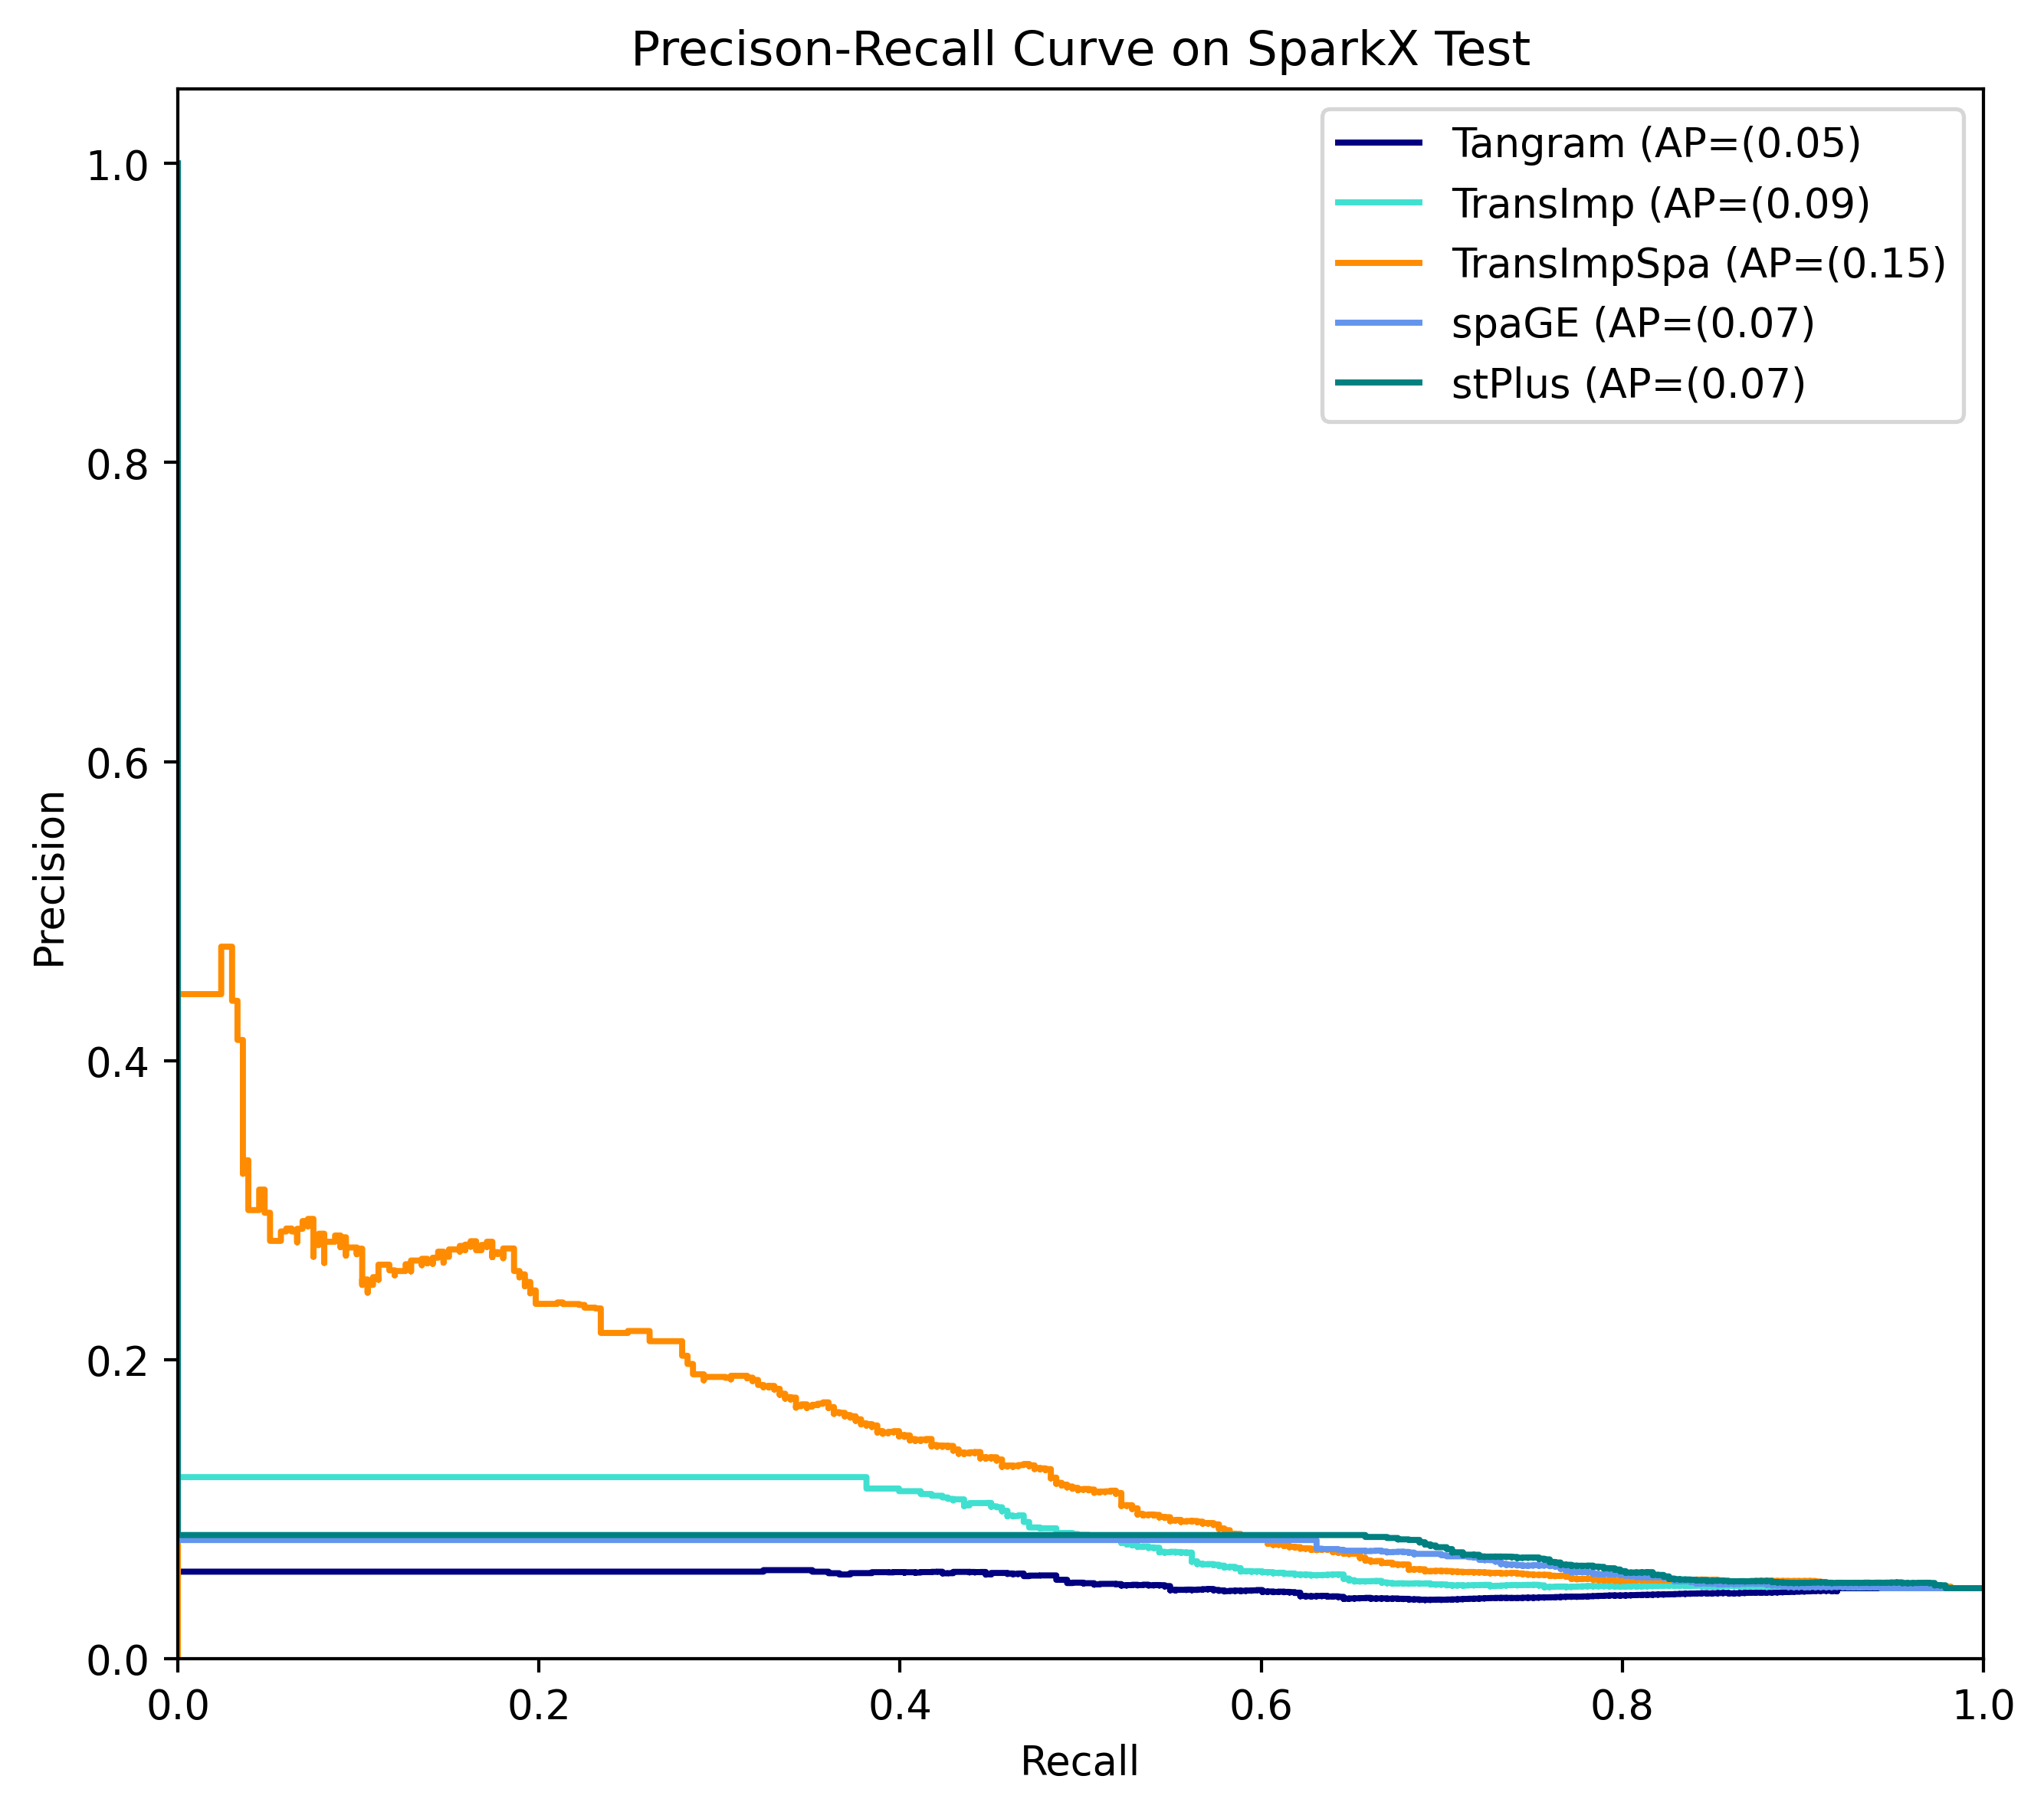

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_adjpvals[method][sel].values
    score = 1 - df_sparkx_cmbpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
    
        
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
        
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 7068/7068
Tangram
FPR: 0.908092
(TransImp) Valid genes: 7068/7068
TransImp
FPR: 0.780104
(TransImpSpa) Valid genes: 7068/7068
TransImpSpa
FPR: 0.707053
(spaGE) Valid genes: 7068/7068
spaGE
FPR: 0.829844
(stPlus) Valid genes: 7068/7068
stPlus
FPR: 0.824202


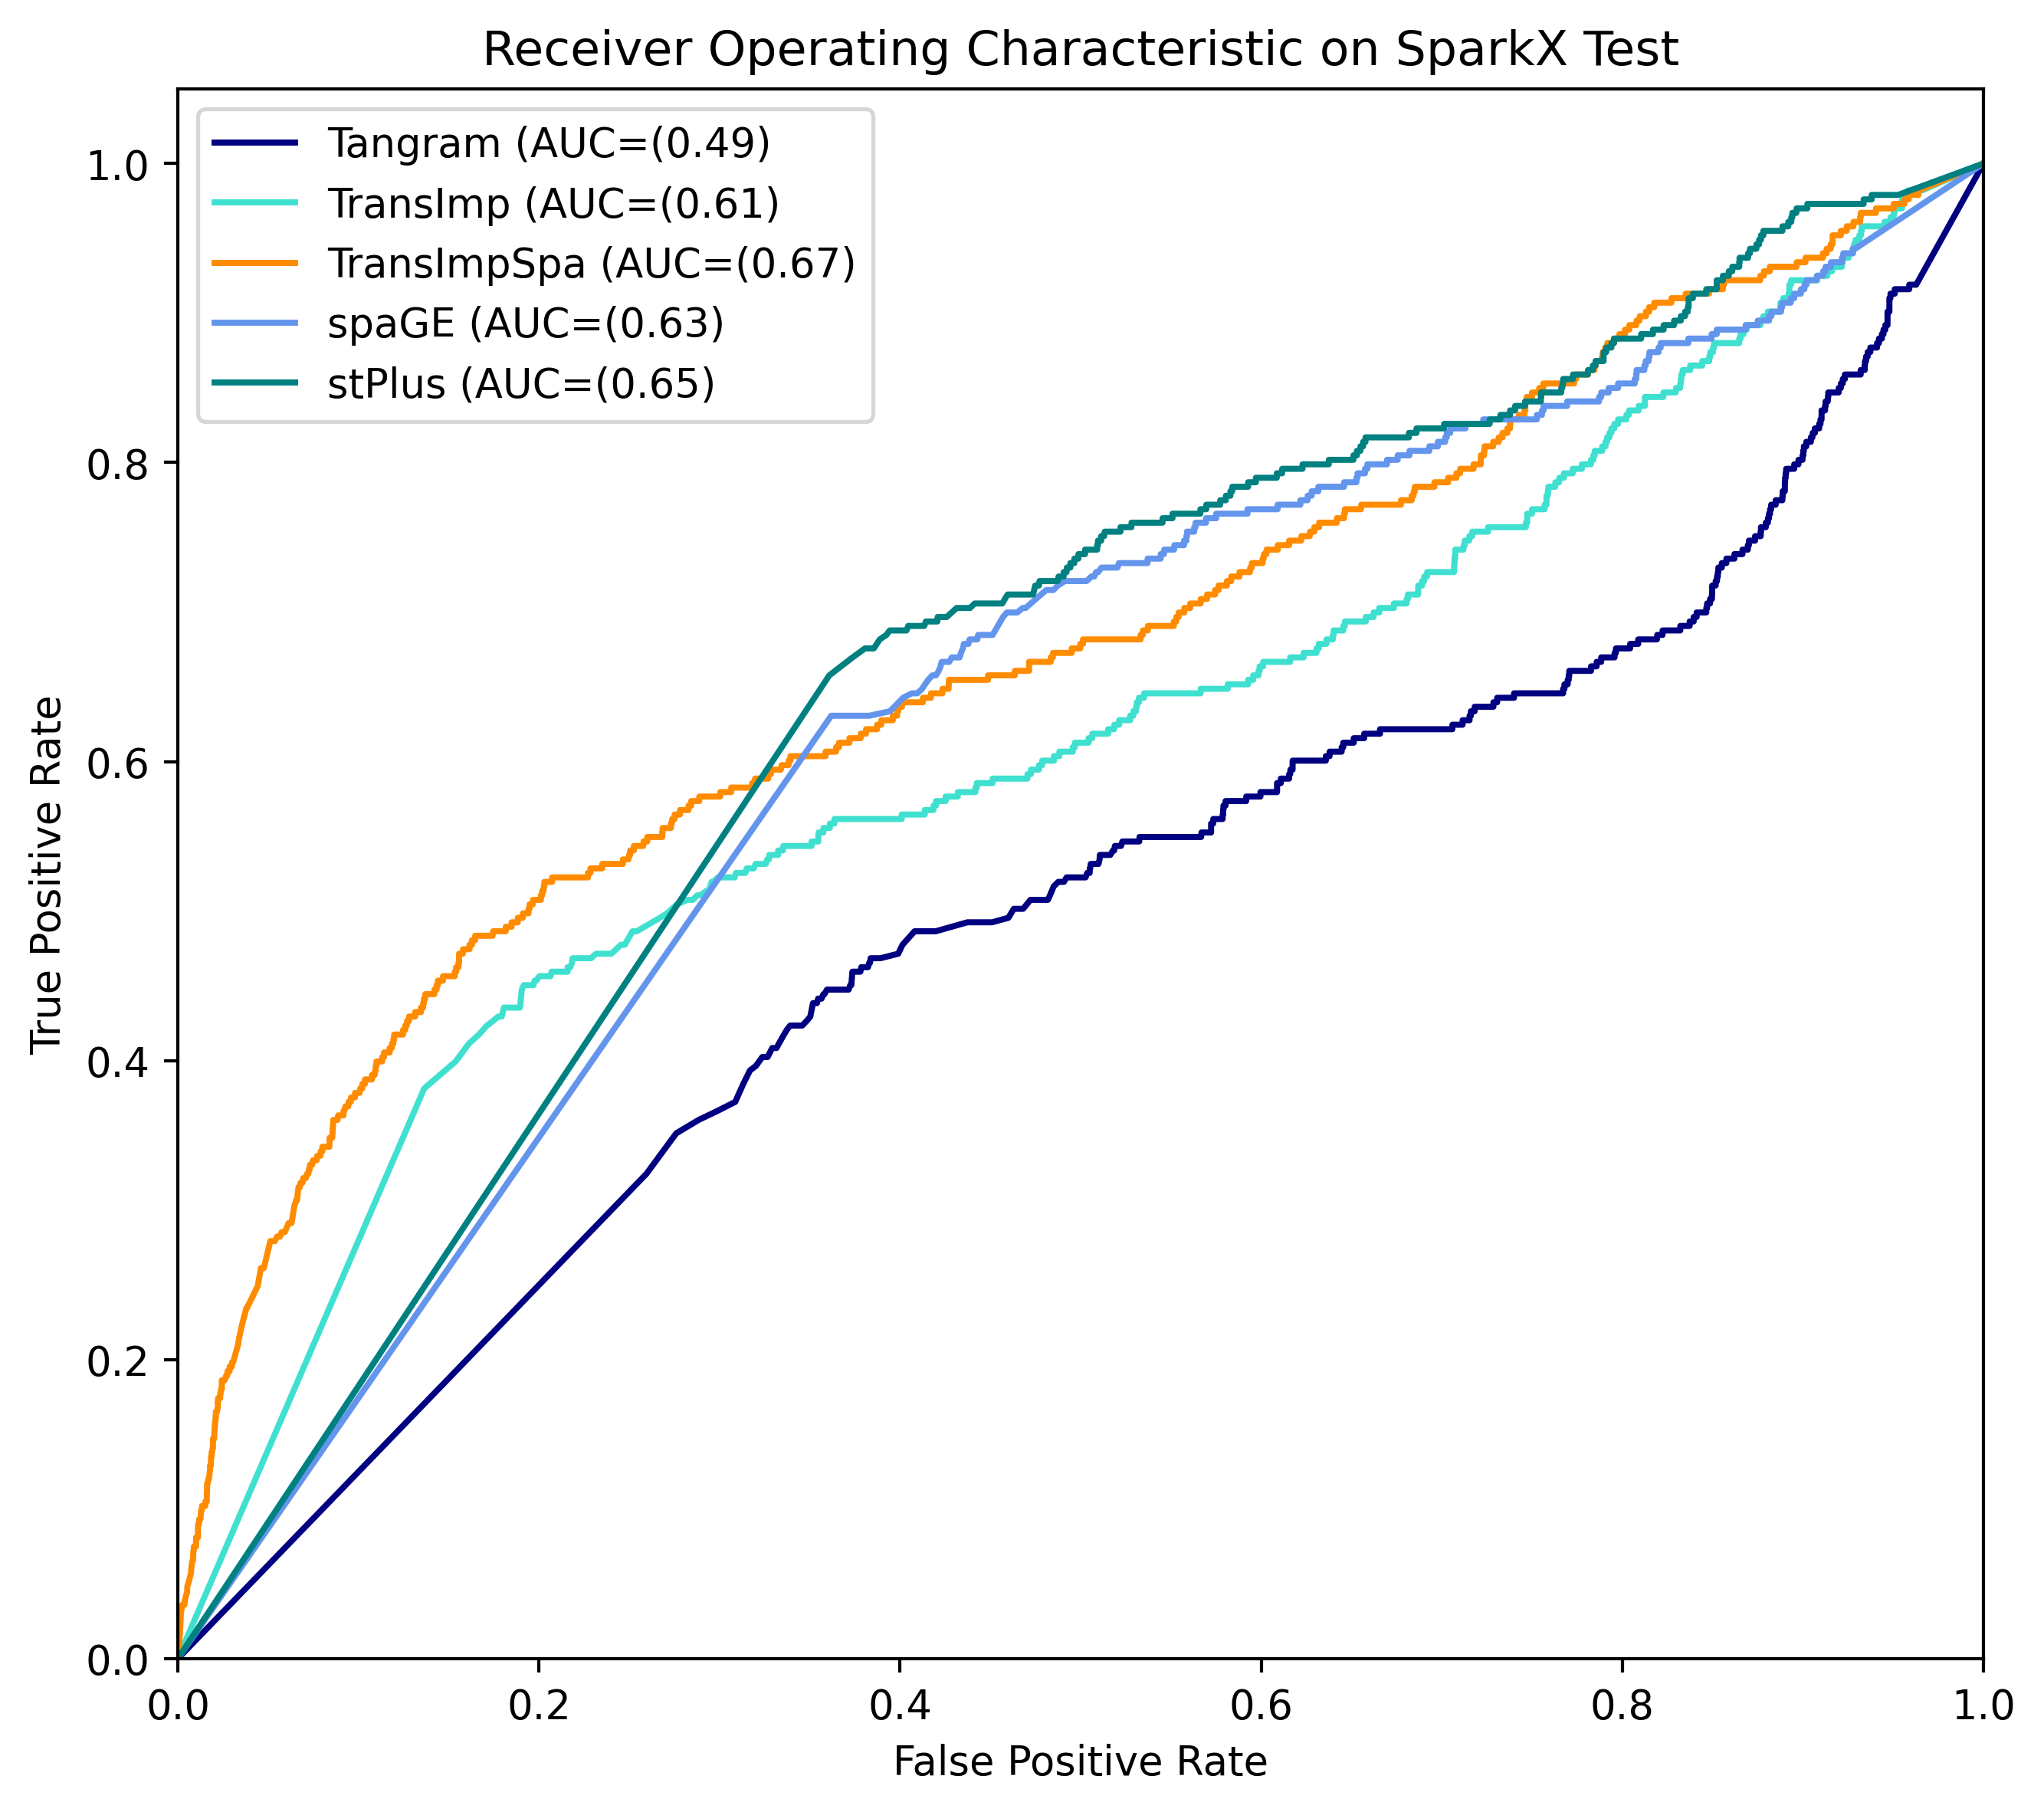

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 7068/7068
Tangram
FPR: 0.908092
prec: 0.042879499217527386, recl: 0.8228228228228228,  F1: 0.08151123010560761
(TransImp) Valid genes: 7068/7068
TransImp
FPR: 0.780104
prec: 0.04818840579710145, recl: 0.7987987987987988,  F1: 0.09089355885870493
(TransImpCls) Valid genes: 7068/7068
TransImpCls
FPR: 0.749220
prec: 0.052750140792190724, recl: 0.8438438438438438,  F1: 0.09929328621908128
(TransImpClsSpa) Valid genes: 7068/7068
TransImpClsSpa
FPR: 0.509874
prec: 0.06634040239260468, recl: 0.7327327327327328,  F1: 0.12166542009473948
(TransImpSpa) Valid genes: 7068/7068
TransImpSpa
FPR: 0.707053
prec: 0.052338308457711445, recl: 0.7897897897897898,  F1: 0.09817095931317656
(spaGE) Valid genes: 7068/7068
spaGE
FPR: 0.829844
prec: 0.04981298877932676, recl: 0.8798798798798799,  F1: 0.09428801287208367
(stPlus) Valid genes: 7068/7068
stPlus
FPR: 0.824202
prec: 0.05078659370725034, recl: 0.8918918918918919,  F1: 0.09610095453810064


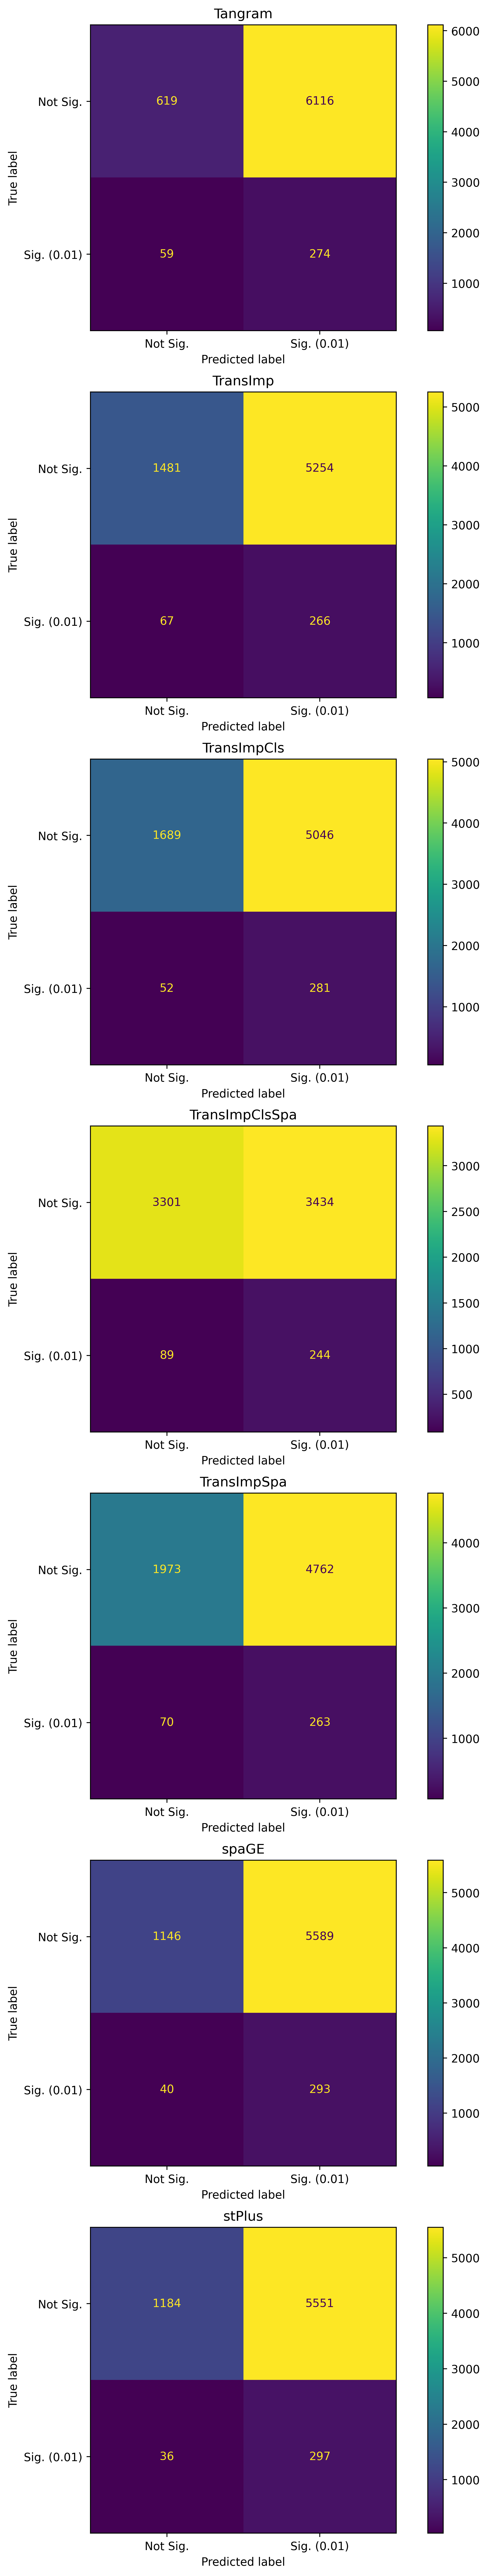

In [ ]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    # if method == "stPlus": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()